# Titanic
#### from kaggle

### 1. 캐글 코드 필사 

제목 : Titanic - Advanced Feature Engineering Tutorial / 저자 : GUNES EVITAN
https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial

#### 0. Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
def concat_df(train_data,test_data):
    return pd.concat([train_data,test_data],sort=True).reset_index(drop=True)

def divide_df(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'],axis=1) # 트레인 데이터가 891개

df_train = pd.read_csv('../Origin Data/train.csv')
df_test = pd.read_csv('../Origin Data/test.csv')
df_all = concat_df(df_train,df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All set'

dfs = [df_train,df_test]

print('Train 데이터 수 = {}'.format(df_train.shape[0]))
print('Test 데이터 수 = {}'.format(df_test.shape[0]))
print('Train Shape : {}'.format(df_train.shape))
print('Test Shape : {}'.format(df_test.shape))
print('Train columns : {}'.format(list(df_train.columns)))
print('Test columns : {}'.format(list(df_test.columns)))

Train 데이터 수 = 891
Test 데이터 수 = 418
Train Shape : (891, 12)
Test Shape : (418, 11)
Train columns : ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Test columns : ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


#### 1. EDA (Exploratory Data Analysis)

##### 1.1 Overview

- PassengerId is the unique id of the row and it doesn't have any effect on target
- Survived is the target variable we are trying to predict (0 or 1):
    - 1 = Survived
    - 0 = Not Survived
- Pclass (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has 3 unique values (1, 2 or 3):
    - 1 = Upper Class
    - 2 = Middle Class
    - 3 = Lower Class
- Name, Sex and Age are self-explanatory
- SibSp is the total number of the passengers' siblings and spouse (배우자/형제자매)
- Parch is the total number of the passengers' parents and children
- Ticket is the ticket number of the passenger
- Fare is the passenger fare
- Cabin is the cabin number of the passenger (선실 번호)
- Embarked is port of embarkation and it is a categorical feature which has 3 unique values (C, Q or S): (승선했던 항구)
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton

In [3]:
print(df_train.info())
print(df_train[['Survived','Age','SibSp','Parch','Fare']].describe())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
         Survived         Age       SibSp       Parch        Fare
count  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838   29.699118    0.523008    0.381594   32.204208
std      0.486592   14.526497    1.102743

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
349,350,0,3,"Dimic, Mr. Jovan",male,42.0,0,0,315088,8.6625,NaN,S
338,339,1,3,"Dahl, Mr. Karl Edwart",male,45.0,0,0,7598,8.0500,NaN,S
865,866,1,2,"Bystrom, Mrs. (Karolina)",female,42.0,0,0,236852,13.0000,NaN,S


In [4]:
print(df_test.info())
print(df_test[['Age','SibSp','Parch','Fare']].describe())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None
              Age       SibSp       Parch        Fare
count  332.000000  418.000000  418.000000  417.000000
mean    30.272590    0.447368    0.392344   35.627188
std     14.181209    0.896760    0.981429   55.907576
min      0.170000    0.000000    0.000000    0.000000
25%     21.

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
44,936,1,"Kimball, Mrs. Edwin Nelson Jr (Gertrude Parsons)",female,45.0,1,0,11753,52.5542,D19,S
218,1110,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.5000,C80,C
155,1047,3,"Duquemin, Mr. Joseph",male,24.0,0,0,S.O./P.P. 752,7.5500,NaN,S


##### 1.2 Missing Values

Training set have missing values in Age, Cabin and Embarked columns  
Test set have missing values in Age, Cabin and Fare columns

In [5]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values : {}'.format(col,df[col].isnull().sum()))
    print('\n')

for df in dfs:
    print('{}'.format(df.name))
    print('data count : {}'.format(df.shape[0]))
    display_missing(df)

Training Set
data count : 891
PassengerId column missing values : 0
Survived column missing values : 0
Pclass column missing values : 0
Name column missing values : 0
Sex column missing values : 0
Age column missing values : 177
SibSp column missing values : 0
Parch column missing values : 0
Ticket column missing values : 0
Fare column missing values : 0
Cabin column missing values : 687
Embarked column missing values : 2


Test Set
data count : 418
PassengerId column missing values : 0
Pclass column missing values : 0
Name column missing values : 0
Sex column missing values : 0
Age column missing values : 86
SibSp column missing values : 0
Parch column missing values : 0
Ticket column missing values : 0
Fare column missing values : 1
Cabin column missing values : 327
Embarked column missing values : 0




1.2.1 Age

단순히 Median 값으로 나이 결측값을 채우는것보단, 나이와 높은 연관성을 가진 Pclass로 범주를 구분하여 Median 값으로 채우는것이 더 좋은 선택으로 보이므로 이를 구현해보겠습니다.

In [6]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort",ascending = False).reset_index()
df_all_corr.rename(columns={"level_0":"Feature 1","level_1":"Feature 2",0:"Correlation Coefficient"},inplace=True)
df_all_corr[df_all_corr['Feature 1']=='Age']

,Feature 1,Feature 2,Correlation Coefficient
0,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
21,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
41,Age,PassengerId,0.028814


여기서 추가로 아래와 같이 성별도 Pclass와 함께 age에 영향을 끼치므로 Sex 도 함께 활용하여 Medain 값을 구해보겠습니다.

###### My Opinion :이런게 중요한 포인트! 
( na 값 채울때 연관성 보고 채우기 [ 이는 결측값 채울때만 쓰이는게 아니라 EDA 를 통해 인사이트를 얻어 어떤걸 처리할때 필요한 항목! ] )

In [7]:
age_by_pclass_sex = df_all.groupby(['Sex','Pclass']).median()['Age']
age_by_pclass_sex

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

In [8]:
df_all.groupby(['Sex','Pclass'])['Age'].apply(lambda x : x.fillna(x.median()))

0       22.0
1       38.0
2       26.0
3       35.0
4       35.0
        ... 
1304    25.0
1305    39.0
1306    38.5
1307    25.0
1308    25.0
Name: Age, Length: 1309, dtype: float64

##### 중요!! groupby 까진 데이터를 기준에 맞게 분류한것이고 아직 아무 집계도 하지 않음! => 거기서 apply를 쓰면 각 그룹의 데이터가 함수에 적용되는 것!

In [9]:
df_all['Age']= df_all.groupby(['Sex','Pclass'])['Age'].apply(lambda x : x.fillna(x.median()))

1.2.2 Embarked

승선한 항구의 정보가 결측값인건 두개 뿐이다. 아래 두개의 정보를 보면 둘다 여자고 1 Pclass 이며, 같은 티켓번호를 가지고있다.  
그러므로 서로 아는 사이이며 같은 항구에서 탔다고 유추해볼 수 있다.


###### My Opinion : 이렇게 생각보다 가진 정보로 유추해볼수 있는 정보는 꽤나 많다. 이런 유추(인사이트)를 잘 얻는것이 중요함!

In [10]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


구글에 이름을 검색해보니 두명 다 S(Southampton) 에서 탄것이 확인된다.

In [11]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

1.2.3 Fare

요금 결측값은 전체 데이터에 하나뿐이다, 요금은 아무래도 가족 사이즈 (Parch and SibSp), Pclass와 연관이 있을것 같다. cor 로 봐도 어느정도 연관 있다고 볼 수 있다.

In [12]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [13]:
df_all_corr=df_all.corr().abs().unstack().sort_values(ascending=False).reset_index()
df_all_corr[df_all_corr['level_0']=='Fare']

,level_0,level_1,0
1,Fare,Fare,1.000000
8,Fare,Pclass,0.558629
16,Fare,Survived,0.257307
18,Fare,Parch,0.221539
22,Fare,Age,0.200039
23,Fare,SibSp,0.160238
40,Fare,PassengerId,0.031428


In [14]:
print(df_all.groupby(['Pclass','Parch','SibSp']).Fare.median())
med_fare = df_all.groupby(['Pclass','Parch','SibSp']).Fare.median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

Pclass  Parch  SibSp
1       0      0         31.33960
               1         75.25000
               2         51.47920
        1      0         63.35830
               1         83.15830
        2      0         83.15830
               1        120.00000
               2        262.37500
               3        263.00000
        3      1        262.37500
        4      1        263.00000
2       0      0         13.00000
               1         26.00000
               2         73.50000
               3         21.00000
        1      0         23.00000
               1         26.25000
               2         33.00000
        2      0         26.25000
               1         41.57920
        3      0         39.00000
               1         23.00000
               2         18.75000
3       0      0          7.85420
               1         14.45625
               2         19.83960
               3         16.92500
        1      0         12.47500
               1         15

###### My Opinion : 위 방법으로 보면 관계성을 찾기 어려울거같은데 => Parch , SibSp를 각각 봐보자

In [15]:
print(print(df_all.groupby('Pclass').Fare.median()))
print(print(df_all.groupby('Parch').Fare.median()))
print(print(df_all.groupby('SibSp').Fare.median()))

Pclass
1    60.0000
2    15.0458
3     8.0500
Name: Fare, dtype: float64
None
Parch
0    10.50000
1    26.00000
2    31.38750
3    34.37500
4    27.90000
5    31.33125
6    46.90000
9    69.55000
Name: Fare, dtype: float64
None
SibSp
0     9.5000
1    26.0000
2    24.1500
3    25.4667
4    31.2750
5    46.9000
8    69.5500
Name: Fare, dtype: float64
None


###### My Opinion : 각각 봐보니 좀 더 명시적이긴하나 3 변수 기준으로 요금의 차이를 볼려면 위에 3개를 동시에 group by 보는게 좋을듯..
###### My Opinion : 이걸 시각화해서 볼 수 있으면 더 좋겠지만 요금 결측은 하나뿐이므로 간단하게 짚고 넘어가는게 좋을듯

1.2.4 Cabin

캐빈은 선실번호인데 많은 결측값을 가지지만 일부 선실의 경우 생존율이 더 높을 가능성이 다분하므로 버리긴 어렵습니다. 캐빈값을 첫번째 글짜는 캐빈이 위치한 데크입니다. 그 갑판은 주로 하나의 승객 등급으로 분리되었지만 일부는 여러 승객 등급에서 사용되었습니다.A, B, C 데크는 1등석 승객 전용,D와 E 덱은 모든 병과용이었습니다.그리고 F와 G 데크는 2등석과 3등석 모두를 위한 것이었습니다.  
A에서 G로 가는 과정에서 생존의 요인이 될 수 있는 계단까지의 거리가 늘어나므로 생존가능성에 큰 부여를 할 수 있을거라 추측됩니다.

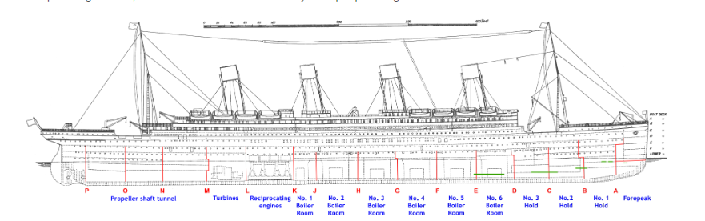

###### My Opinion : 보통 공모전 데이터에선 이런걸 직접 찾아봐도 안나오는 경우가 많아서 조사도 안하는 경우가 많은데 이런걸 놓치면 안된다! 데이터를 제대로 확인하는 1단계 과정이 정말 중요하다는걸  다시 배우는 기회

###### My Opinion : 왜 Cabin 이 없을까? 현대 기준으로 하면 티켓정보에 보통 어느 객실인지 나오는데 티켓 번호는 있고 숙실 정보가 없는게 의아하다.

In [16]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s : s[0] if pd.notnull(s) else 'M') ## 결측은 전부 M
df_all_decks = df_all.groupby(['Deck','Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()
print(df_all_decks)
df_all.groupby(['Deck','Pclass']).count()[['Name']].rename(columns={'Name':'Count'}).transpose()
## 아래 것도 같은 과정 임! 굳이 drop 안써도 될듯?

Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1


Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

##### My Opinion : 1호실 결측값이 적은데 1호실 인원이 적어서 그런건가 ? 아니면 살아남은 사람들이 1호실이 많아서 살아남은 후 객실 정보를 알려줘서 적은건가?

            0          1           2
A  100.000000   0.000000    0.000000
B  100.000000   0.000000    0.000000
C  100.000000   0.000000    0.000000
D   86.956522  13.043478    0.000000
E   82.926829   9.756098    7.317073
F    0.000000  61.904762   38.095238
G    0.000000   0.000000  100.000000
M    6.607495  25.049310   68.343195
T  100.000000   0.000000    0.000000


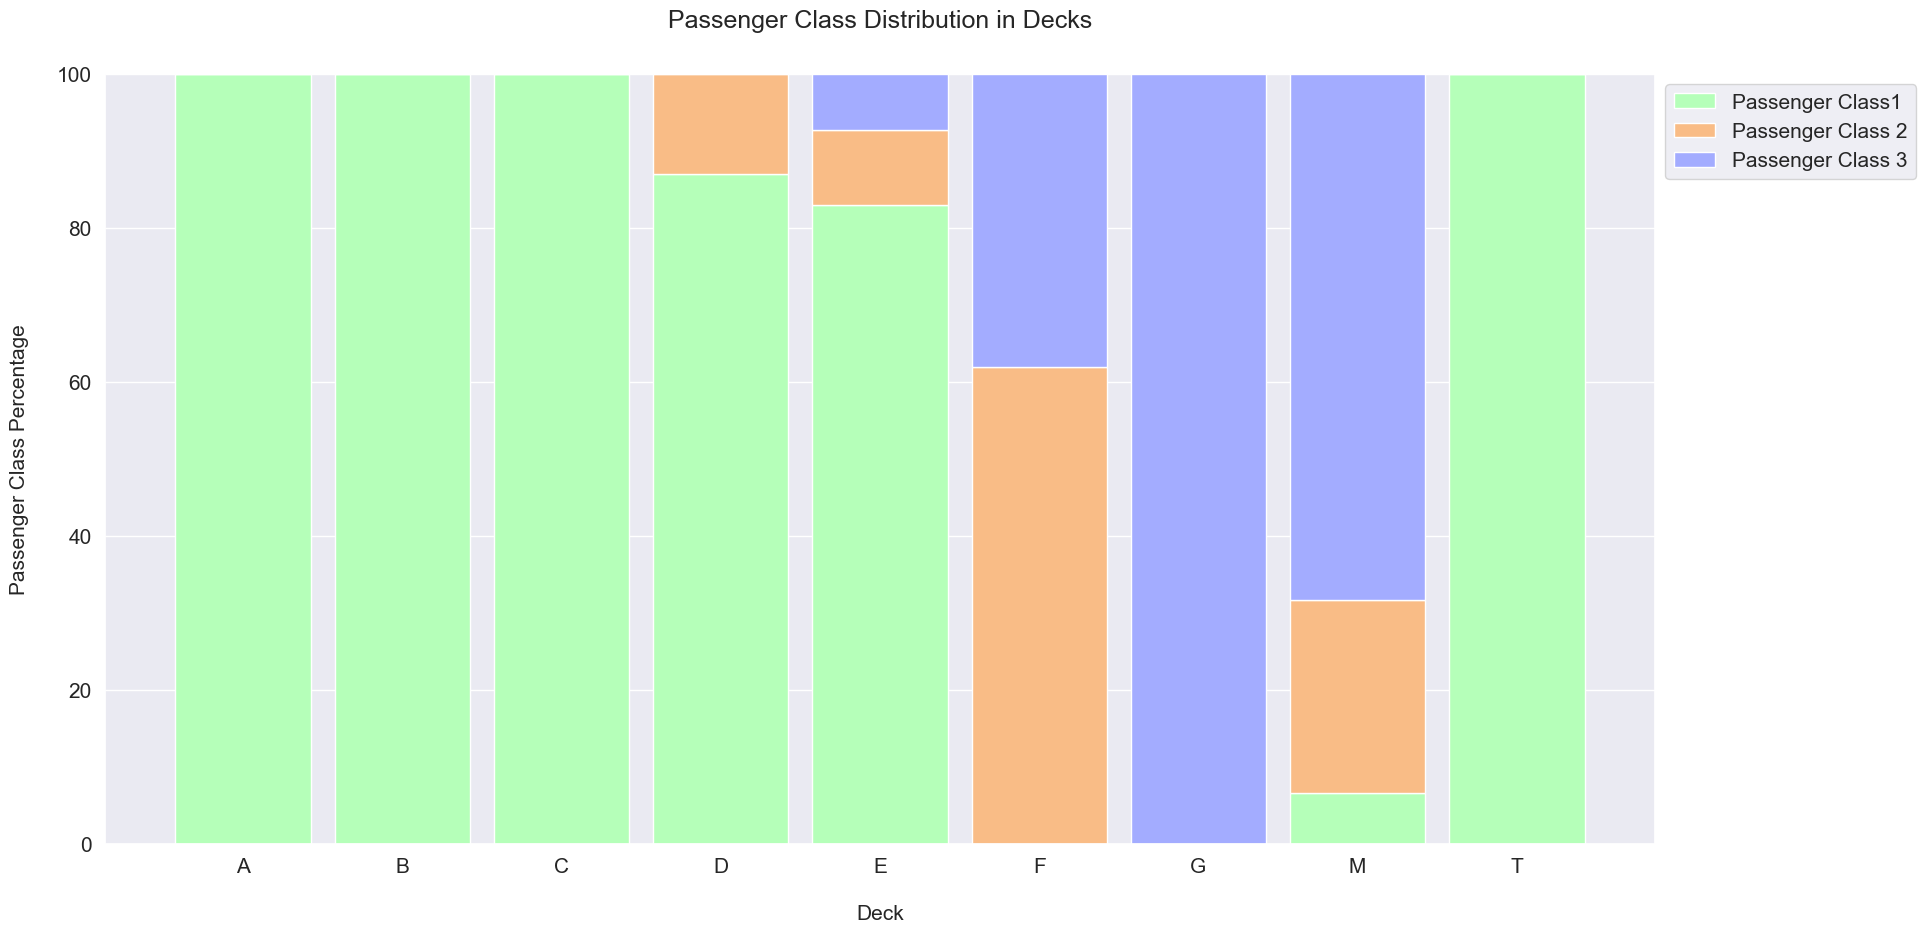

In [37]:
def get_pclass_dist(df):
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]
    for deck in decks:
        for pclass in range(1,4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count
            except KeyError:
                deck_counts[deck][pclass] = 0
    df_decks = pd.DataFrame(deck_counts)
    deck_percentages = {}
    
    for col in df_decks.columns:
        deck_percentages[col] = [(count/df_decks[col].sum())*100 for count in df_decks[col]]
        
    return deck_counts,deck_percentages

def display_pclass_dist(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    print(df_percentages)
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize = (20,10))
    plt.bar(bar_count,pclass1,color='#b5ffb9',edgecolor = 'white',width=bar_width,label='Passenger Class1')
    plt.bar(bar_count,pclass2,bottom =pclass1,color='#f9bc86',edgecolor='white',width=bar_width,label='Passenger Class 2')
    plt.bar(bar_count,pclass3,bottom = pclass1+pclass2,color='#a3acff',edgecolor='white',width=bar_width,label='Passenger Class 3')
    
    plt.xlabel('Deck',size=15,labelpad=20)
    plt.ylabel('Passenger Class Percentage',size=15,labelpad=20)
    plt.xticks(bar_count,deck_names)
    plt.tick_params(axis='x',labelsize=15)
    plt.tick_params(axis='y',labelsize=15)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [22]:
df_all_decks.columns.levels ## group by 된 데이터프레임이라 그런지 컬럼에 레벨이 있음

FrozenList([['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T'], [1, 2, 3]])

##### my Opinion : 혀니가 얘기해준 그래프 라이브러리로도 그려보기

T는 한명 뿐인데 1class 이므로 100프로 1등급 클래스인 A랑 묶어준다.  
객실 정보가 없는것을 찾긴 어려우니 M 객실로 그냥 사용한다.

In [42]:
df_all.loc[df_all['Deck']=='T','Deck'] = 'A'

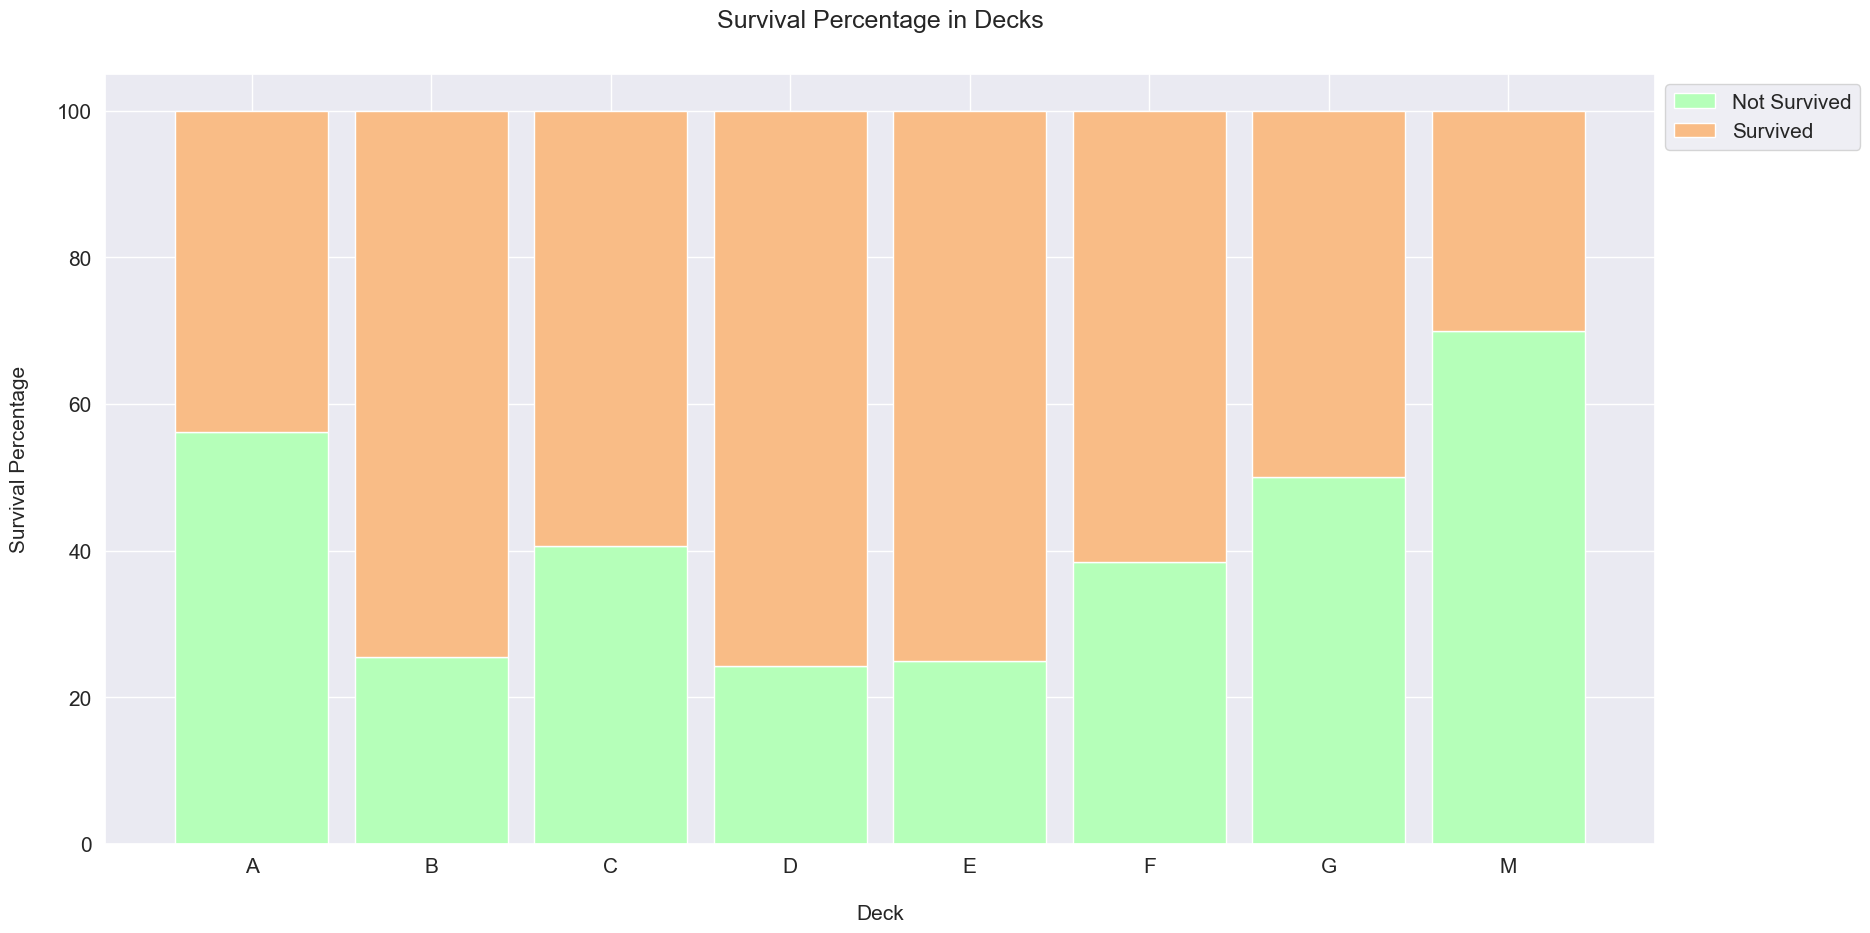

In [43]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)